In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from helper import * 

# IV skew 的统计分析

## 1. IV Skew 的本质  

- **隐含波动率曲线（IV Curve）**：同一到期日、不同执行价的期权，其隐含波动率通常会随着执行价高低而有系统性变化──这就是 IV 曲线。  
- **整体 Skew（Slope）**：把执行价的对数偏离度 $\log(K/S)$（log-moneyness）当自变量，IV 做线性回归，回归斜率即整体 Skew。  
- **局部 Skew（Local Skew 或 Skew per Step）**：用相邻档位的 IV 差分近似导出数值，更聚焦于每个 strike 附近的斜度。

---

## 2. 用 ATM 基准和步长计算 `skew_per_step`  

1. **确定 ATM**  
   - 每分钟（及每个到期日）选出最接近底层价格 $S$ 的执行价 $K_{\rm atm}$，并取其 IV 为 $\text{IV}_{\rm atm}$。  
2. **量化步长**  
   - CF 合约的最小行权价步长是 200 点。  
   - 定义  
     $$
       \Delta_\text{steps} = \frac{K - K_{\rm atm}}{200}
     $$
3. **局部偏度**  
   - 对每一行  
     $$
       \text{skew\_per\_step} \;=\;
       \frac{\text{IV}(K) - \text{IV}_{\rm atm}}{\Delta_\text{steps}}
       \quad(\Delta_\text{steps}\neq0)
     $$
   - ATM 档位 $\Delta_\text{steps}=0$ 时，可将 `skew_per_step` 设为 NaN。

---

## 3. 滚动分位数：捕捉 “异常” Skew  

我们要知道在历史同档位下，这个 `skew_per_step` 正常分布在哪里，然后当前值落在某个极端分位就发信号。

1. **按档位分组**  
   $$
     \text{for each }\;d\in\{\dots,-2,-1,1,2,\dots\}:\;
     X_{d,t} = \bigl\{\text{skew\_per\_step}(t') \mid \Delta_\text{steps}=d,\;t'\le t\}
   $$
2. **滑动窗口**  
   - 用过去 $W$ 条记录（或过往 $D$ 交易日同一分钟点的样本）做窗口。  
   - 窗口大小建议：$W\approx3\text{天}\times240\text{分钟}=720$条，或按分钟数直接定 $W$。  
3. **计算 quantile**  
   - 对每组 $X_{d,t}$ 维护  
     $
       q_{d,t}^{\alpha} = \operatorname{Quantile}\bigl(X_{d,t},\,\alpha\bigr)
     $
   - 常用 $\alpha=0.90,0.95$（做 Put Spread）、$\alpha=0.10,0.05$（做 Call Spread）。
4. **信号触发**  
   - **做多 Put Spread**（捕捉恐慌过度）：  
     $$
       \text{if }\;\text{skew\_per\_step}_{t}>q^{0.90}_{d,t}
     $$
   - **做多 Call Spread**（捕捉乐观过度）：  
     $$
       \text{if }\;\text{skew\_per\_step}_{t}<q^{0.10}_{d,t}
     $$

---

## 4. 实践要点与优化  

- **最低档位筛选**：一般跳过 $|\Delta_\text{steps}|<2$的档位，过滤流动性差、噪声大的近 ATM 档。  
- **最少样本期**：window 内至少保留 $\min\_periods$个样本（例如 1000 条）再开始计算 quantile，避免极端失真。  
- **平滑处理**：如信号过于抖动，可对 `skew_per_step` 做短窗口（3–5 分钟） rolling mean，再比较分位数。  
- **信号冷却**：一旦同档位触发信号，设置几分钟内不重复进场，防止高频震荡。  
- **止盈止损**：例如 skew 回归至历史中位数（50% 分位）时平仓，或达到固定持有分钟数后强制平仓。  
- **回测验证**：  
  1. 在历史分钟线数据上模拟开／平仓，记录 P&L 曲线、胜率、Sharpe。  
  2. 网格搜索 $\{\alpha\in[0.90,0.95],\,W\in[2000,10000],\,|\Delta_\text{steps}|\ge2\}$ 等参数组合。  

---

### 小结

- **核心指标**：`skew_per_step = (IV - IV_atm)/Δsteps`，反映相对于 ATM 的局部斜度。  
- **信号逻辑**：基于每个档位 `skew_per_step` 的历史滚动分位极值，判断“偏高”或“偏低”再做对应价差。  
- **关键落地**：窗口期 $W$、分位度 $\alpha$、档位筛选、平滑与冷却等参数都需回测验证才能定下来。



## 初始化

In [2]:
path="opt_test_data/CF_options_data.parquet"
size=200
CF=Option_strat(path,size)

In [3]:
df=CF.read_df(path)

In [4]:
df

,minute_str,Instrument,mean_ask,mean_bid,cumcashvol,cumvolume,openinterest,is_call,strike,maturity,underly_mean_mid,mean_mid,twap,date_str,minute,T
0,2024-06-03 21:00,CF2409C14800,502.136364,487.363636,7430.0,3.0,745.0,True,14800.0,70.0,14978.409091,494.750000,496.181818,2024-06-03,2024-06-03 21:00:00,0.277778
1,2024-06-03 21:00,CF2409C15000,394.100000,388.560000,19350.0,10.0,1306.0,True,15000.0,70.0,14987.900000,391.330000,391.940000,2024-06-03,2024-06-03 21:00:00,0.277778
2,2024-06-03 21:00,CF2409C15400,223.000000,217.375000,5540.0,5.0,0.0,True,15400.0,70.0,14979.375000,220.187500,222.125000,2024-06-03,2024-06-03 21:00:00,0.277778
3,2024-06-03 21:00,CF2409C16000,107.720000,106.520000,18270.0,34.0,17810.0,True,16000.0,70.0,14978.700000,107.120000,107.480000,2024-06-03,2024-06-03 21:00:00,0.277778
4,2024-06-03 21:00,CF2409C16200,84.500000,82.000000,420.0,1.0,0.0,True,16200.0,70.0,14977.500000,83.250000,84.000000,2024-06-03,2024-06-03 21:00:00,0.277778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608278,2024-08-14 22:59,CF2501P13800,709.555556,631.777778,368725.0,110.0,4279.0,False,13800.0,118.0,13354.722222,670.666667,703.000000,2024-08-14,2024-08-14 22:59:00,0.468254
608279,2024-08-14 22:59,CF2501P14000,853.000000,810.454545,220160.0,55.0,6067.0,False,14000.0,118.0,13354.772727,831.727273,824.000000,2024-08-14,2024-08-14 22:59:00,0.468254
608280,2024-08-14 22:59,CF2501P14200,1009.666667,943.333333,207045.0,43.0,3805.0,False,14200.0,118.0,13354.166667,976.500000,983.000000,2024-08-14,2024-08-14 22:59:00,0.468254
608281,2024-08-14 22:59,CF2501P14400,1150.000000,1093.833333,65785.0,12.0,1905.0,False,14400.0,118.0,13352.500000,1121.916667,1142.000000,2024-08-14,2024-08-14 22:59:00,0.468254


### 计算iv

In [5]:
df_iv=CF.add_iv(df)

#### 同一strike，平均化iv

In [6]:
df_iv=CF.ave_iv(df_iv)

In [9]:
df_iv.head(30)

,minute_str,Instrument,mean_ask,mean_bid,cumcashvol,cumvolume,openinterest,is_call,strike,maturity,underly_mean_mid,mean_mid,twap,date_str,minute,T,iv,iv_mean,underly_F
0,2024-06-03 21:00,CF2409C14800,502.136364,487.363636,7430.0,3.0,745.0,True,14800.0,70.0,14978.409091,494.750000,496.181818,2024-06-03,2024-06-03 21:00:00,0.277778,0.127546,0.128394,14980
1,2024-06-03 21:00,CF2409C15000,394.100000,388.560000,19350.0,10.0,1306.0,True,15000.0,70.0,14987.900000,391.330000,391.940000,2024-06-03,2024-06-03 21:00:00,0.277778,0.126060,0.126924,14980
2,2024-06-03 21:00,CF2409C15400,223.000000,217.375000,5540.0,5.0,0.0,True,15400.0,70.0,14979.375000,220.187500,222.125000,2024-06-03,2024-06-03 21:00:00,0.277778,0.123838,0.123838,14980
3,2024-06-03 21:00,CF2409C16000,107.720000,106.520000,18270.0,34.0,17810.0,True,16000.0,70.0,14978.700000,107.120000,107.480000,2024-06-03,2024-06-03 21:00:00,0.277778,0.135901,0.135901,14980
4,2024-06-03 21:00,CF2409C16200,84.500000,82.000000,420.0,1.0,0.0,True,16200.0,70.0,14977.500000,83.250000,84.000000,2024-06-03,2024-06-03 21:00:00,0.277778,0.139211,0.139211,14980
5,2024-06-03 21:00,CF2409C18400,27.200000,26.000000,310.0,2.0,26912.0,True,18400.0,70.0,14977.500000,26.600000,31.000000,2024-06-03,2024-06-03 21:00:00,0.277778,0.216261,0.216261,14980
6,2024-06-03 21:00,CF2409P13800,84.250000,79.625000,5295.0,13.0,3955.0,False,13800.0,70.0,14975.625000,81.937500,81.250000,2024-06-03,2024-06-03 21:00:00,0.277778,0.146154,0.146154,14976
7,2024-06-03 21:00,CF2409P14200,142.631579,138.578947,12745.0,18.0,0.0,False,14200.0,70.0,14982.236842,140.605263,138.526316,2024-06-03,2024-06-03 21:00:00,0.277778,0.137323,0.137323,14976
8,2024-06-03 21:00,CF2409P14400,189.666667,184.888889,7500.0,8.0,5919.0,False,14400.0,70.0,14976.388889,187.277778,187.444444,2024-06-03,2024-06-03 21:00:00,0.277778,0.133797,0.133797,14976
9,2024-06-03 21:00,CF2409P14600,252.000000,250.500000,25100.0,20.0,7909.0,False,14600.0,70.0,14972.500000,251.250000,251.000000,2024-06-03,2024-06-03 21:00:00,0.277778,0.132205,0.132205,14976


In [17]:
df_iv=CF.get_underly_F(df_iv)

In [18]:
df_iv.head(30)

,minute_str,Instrument,mean_ask,mean_bid,cumcashvol,cumvolume,openinterest,is_call,strike,maturity,underly_mean_mid,mean_mid,twap,date_str,minute,T,iv,iv_mean,underly_F
0,2024-06-03 21:00,CF2409C14800,502.136364,487.363636,7430.0,3.0,745.0,True,14800.0,70.0,14978.409091,494.750000,496.181818,2024-06-03,2024-06-03 21:00:00,0.277778,0.127546,0.128394,14980
1,2024-06-03 21:00,CF2409C15000,394.100000,388.560000,19350.0,10.0,1306.0,True,15000.0,70.0,14987.900000,391.330000,391.940000,2024-06-03,2024-06-03 21:00:00,0.277778,0.126060,0.126924,14980
2,2024-06-03 21:00,CF2409C15400,223.000000,217.375000,5540.0,5.0,0.0,True,15400.0,70.0,14979.375000,220.187500,222.125000,2024-06-03,2024-06-03 21:00:00,0.277778,0.123838,0.123838,14980
3,2024-06-03 21:00,CF2409C16000,107.720000,106.520000,18270.0,34.0,17810.0,True,16000.0,70.0,14978.700000,107.120000,107.480000,2024-06-03,2024-06-03 21:00:00,0.277778,0.135901,0.135901,14980
4,2024-06-03 21:00,CF2409C16200,84.500000,82.000000,420.0,1.0,0.0,True,16200.0,70.0,14977.500000,83.250000,84.000000,2024-06-03,2024-06-03 21:00:00,0.277778,0.139211,0.139211,14980
5,2024-06-03 21:00,CF2409C18400,27.200000,26.000000,310.0,2.0,26912.0,True,18400.0,70.0,14977.500000,26.600000,31.000000,2024-06-03,2024-06-03 21:00:00,0.277778,0.216261,0.216261,14980
6,2024-06-03 21:00,CF2409P13800,84.250000,79.625000,5295.0,13.0,3955.0,False,13800.0,70.0,14975.625000,81.937500,81.250000,2024-06-03,2024-06-03 21:00:00,0.277778,0.146154,0.146154,14976
7,2024-06-03 21:00,CF2409P14200,142.631579,138.578947,12745.0,18.0,0.0,False,14200.0,70.0,14982.236842,140.605263,138.526316,2024-06-03,2024-06-03 21:00:00,0.277778,0.137323,0.137323,14976
8,2024-06-03 21:00,CF2409P14400,189.666667,184.888889,7500.0,8.0,5919.0,False,14400.0,70.0,14976.388889,187.277778,187.444444,2024-06-03,2024-06-03 21:00:00,0.277778,0.133797,0.133797,14976
9,2024-06-03 21:00,CF2409P14600,252.000000,250.500000,25100.0,20.0,7909.0,False,14600.0,70.0,14972.500000,251.250000,251.000000,2024-06-03,2024-06-03 21:00:00,0.277778,0.132205,0.132205,14976


### 确定ATM strike，计算local skew

* 选择ATM iv，根据200的价差去计算skew，这样统计分位数，也方便去交易。

* 其实到了这一步，可以去构建vol surface，看是否有 non-convex 套利的机会

In [19]:
df_skew=CF.get_local_skew(df_iv)

In [20]:
df_skew

,minute_str,Instrument,mean_ask,mean_bid,cumcashvol,cumvolume,openinterest,is_call,strike,maturity,...,date_str,minute,T,iv,iv_mean,underly_F,strike_atm,iv_atm,strike_diff_steps,skew_per_step
0,2024-06-03 21:00,CF2409P13800,84.250000,79.625000,5295.0,13.0,3955.0,False,13800.0,70.0,...,2024-06-03,2024-06-03 21:00:00,0.277778,0.146154,0.146154,14976,15000.0,0.126060,-6,-0.003349
1,2024-06-03 21:00,CF2409P14200,142.631579,138.578947,12745.0,18.0,0.0,False,14200.0,70.0,...,2024-06-03,2024-06-03 21:00:00,0.277778,0.137323,0.137323,14976,15000.0,0.126060,-4,-0.002816
2,2024-06-03 21:00,CF2409P14400,189.666667,184.888889,7500.0,8.0,5919.0,False,14400.0,70.0,...,2024-06-03,2024-06-03 21:00:00,0.277778,0.133797,0.133797,14976,15000.0,0.126060,-3,-0.002579
3,2024-06-03 21:00,CF2409P14600,252.000000,250.500000,25100.0,20.0,7909.0,False,14600.0,70.0,...,2024-06-03,2024-06-03 21:00:00,0.277778,0.132205,0.132205,14976,15000.0,0.126060,-2,-0.003072
4,2024-06-03 21:00,CF2409C14800,502.136364,487.363636,7430.0,3.0,745.0,True,14800.0,70.0,...,2024-06-03,2024-06-03 21:00:00,0.277778,0.127546,0.128394,14980,15000.0,0.126060,-1,-0.001485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608278,2024-08-14 22:59,CF2501C15800,27.800000,20.000000,35690.0,335.0,3253.0,True,15800.0,118.0,...,2024-08-14,2024-08-14 22:59:00,0.468254,0.141966,0.141966,13355,13400.0,0.122625,12,0.001612
608279,2024-08-14 22:59,CF2501C16000,20.000000,16.833333,50020.0,504.0,7847.0,True,16000.0,118.0,...,2024-08-14,2024-08-14 22:59:00,0.468254,0.143357,0.143357,13355,13400.0,0.122625,13,0.001595
608280,2024-08-14 22:59,CF2501C16200,18.000000,16.000000,10010.0,118.0,3760.0,True,16200.0,118.0,...,2024-08-14,2024-08-14 22:59:00,0.468254,0.149273,0.149273,13355,13400.0,0.122625,14,0.001903
608281,2024-08-14 22:59,CF2501C16800,14.000000,12.000000,70.0,1.0,2958.0,True,16800.0,118.0,...,2024-08-14,2024-08-14 22:59:00,0.468254,0.164730,0.164730,13355,13400.0,0.122625,17,0.002477


#### ATM iv 可视化


In [22]:
atm_iv=CF.get_atm_iv(df_skew)

<Axes: xlabel='minute'>

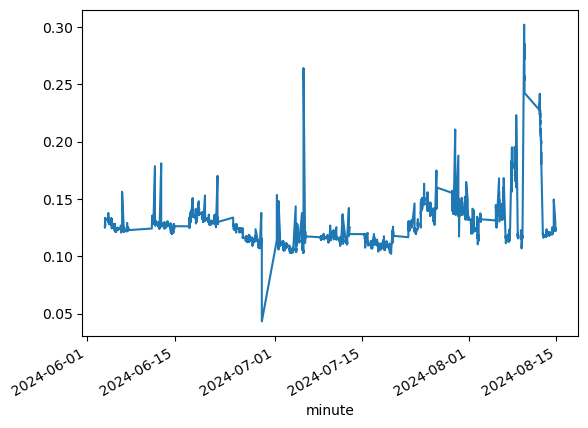

In [23]:
atm_iv.iv_atm.plot()

**ATM IV trading**:

* 第一，检测并确认是否需要过滤掉outliers。
* 第二，可以直接计算rolling quantile交易ATM IV。
* 第三，可以对ATM IV运用时间序列分析或者预测，比如 LSTM，去预测IV。

不过此次分析不在此方向展开，主要研究local skew。

#### 可视化skew统计性质

* 确定是否有均值回归现象。
* 确定哪些diff step 存在比较明显的均值回归。
* 确定均值回归的平均时间（半衰期）。

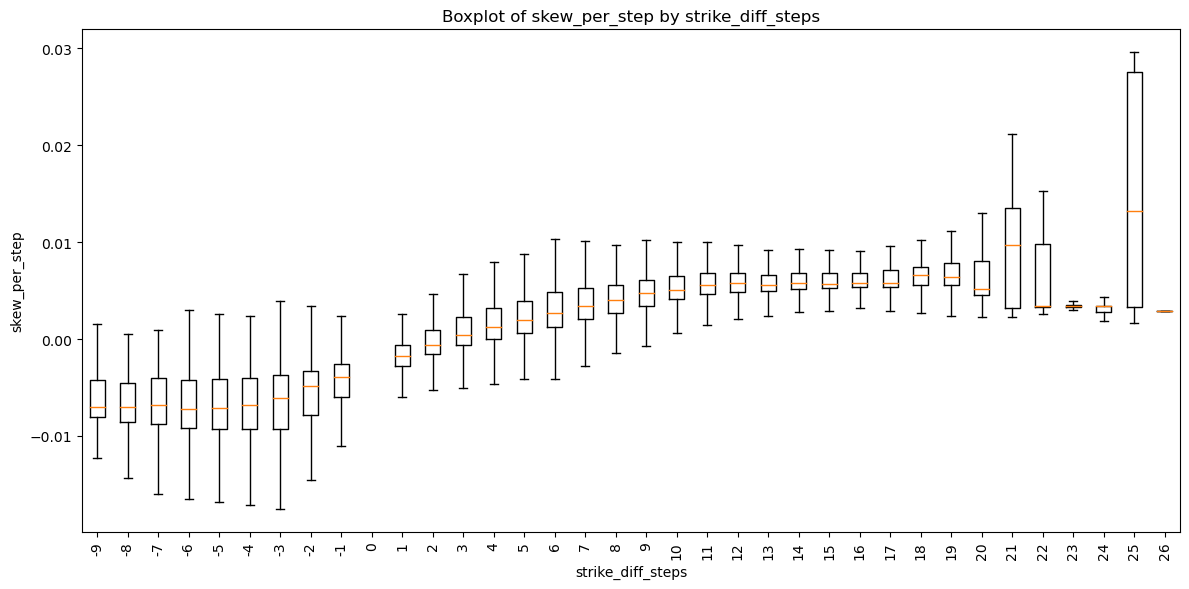

In [25]:
CF.plot_box(df_skew)

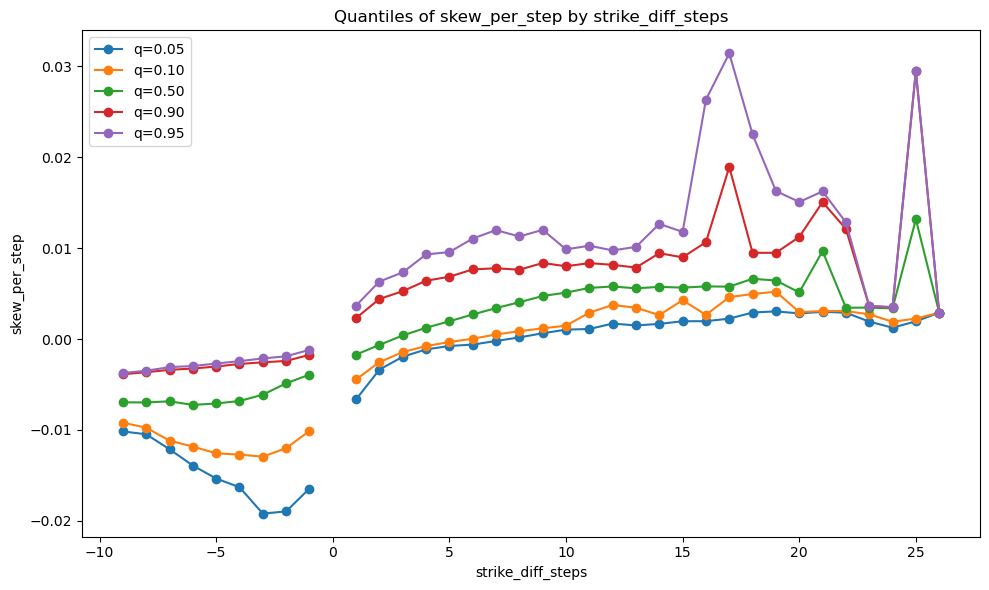

In [26]:
CF.plot_quantile(df_skew)

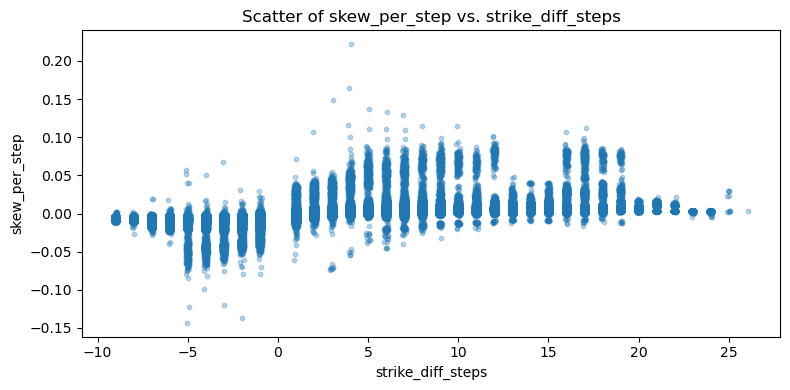

In [27]:
CF.plot_scatter(df_skew)

In [29]:
CF_sig=Signals([0.1,0.9])

In [31]:
events_df=CF_sig.get_signals(df_skew)

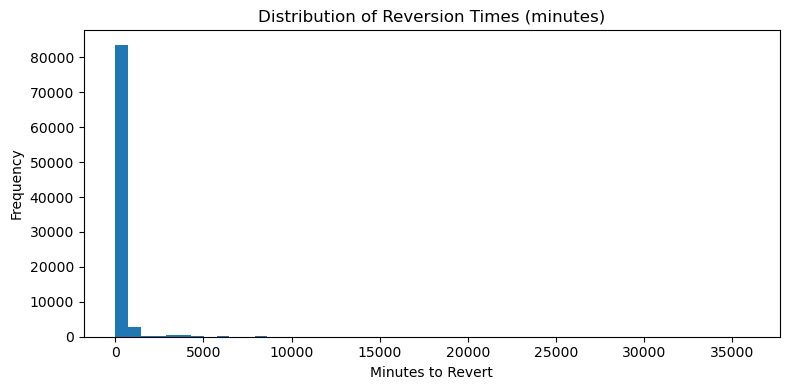

<Figure size 1000x400 with 0 Axes>

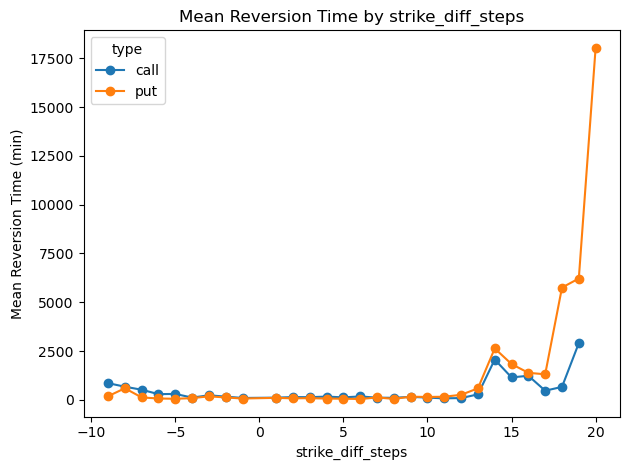

Overall mean reversion times (min):
type
call    196.305747
put     192.579724
Name: dt, dtype: float64


In [32]:
events_df,agg=CF_sig.plot(events_df)

In [33]:
agg

type,call,put
steps,,
-9,856.127907,184.250000
-8,673.553931,593.664773
-7,518.280908,124.094170
-6,292.423398,69.277596
-5,303.573094,54.998219
-4,115.742074,87.292718
-3,233.009035,180.185169
-2,164.881903,122.744311
-1,97.043113,68.345238


#### 结论

* 选择step size 从-5，到10.
* 选择qunatile0.05和0.95作为入场信号，quantile 0.5 作为平仓信号。

### 回测

In [34]:
df = df_skew.sort_values(['strike_diff_steps', 'minute']).reset_index(drop=True)


In [35]:
CF.bact_test(df)

总笔数： 34675
总 PnL： -756092.0699908406
平均单笔 PnL： -21.805106560658707
胜率： 0.008478731074260995
      count       mean            sum        std
type                                            
call  17618 -16.365308 -288323.994854  61.510724
put   17057 -27.423819 -467768.075137  49.319717
       count       mean
steps                  
-4      1803 -25.430008
-3      2829 -33.515508
-2      3136 -20.277656
-1      3073 -20.315100
 2      3194 -17.203696
 3      3749 -16.103733
 4      3634 -20.821834
 5      3059 -21.065242
 6      2383 -21.111685
 7      2127 -22.425160
 8      1899 -22.841337
 9      1108 -20.290654
 10      820 -20.922381
 11      899 -29.436377
 12      615 -28.293356
 13      347 -26.211713


提高quantile阈值，减少交易频率。

In [36]:
CF.bact_test(df_skew.sort_values(['strike_diff_steps', 'minute']).reset_index(drop=True),quantile=[0.02,0.98])

总笔数： 18725
总 PnL： -518229.58060309547
平均单笔 PnL： -27.675812048229396
胜率： 0.0067289719626168224
      count       mean            sum        std
type                                            
call   8872 -22.097222 -196046.554149  85.233394
put    9853 -32.698978 -322183.026454  61.034954
       count       mean
steps                  
-4       918 -35.207235
-3      1483 -43.331000
-2      1750 -29.177288
-1      1612 -25.576690
 2      1812 -20.248107
 3      2012 -19.982134
 4      2079 -26.263410
 5      1660 -25.282597
 6      1255 -25.064912
 7      1118 -29.182202
 8      1025 -29.562075
 9       628 -25.642058
 10      442 -25.745564
 11      488 -38.450857
 12      265 -36.288659
 13      178 -31.734082


结论分析：

稳定亏损，可能存在的原因。

* 直接take ask-bid spread，两次，spread过大会直接吃掉潜在的收益。
* 未考虑持仓时间，theta上亏钱。
* 平仓线太粗糙了，应该设计分批入仓、分批出场以及止损。
* 分钟线上，交易频率太高。考虑5min重新设计策略。